# Customer Service Flow Analysis 

## Background

All of the data seen below is for the client SharkNinja. They recently launched 5 new flows that presumably survey clients in 5 distinct countries about their customer service experience. 

## Objective

This analysis strives to better understand the flows, when they started, how they have preformed over time, and what they look like from a user's perspective. 

In [83]:
import sys
sys.path.append("..")

import os
from google.cloud import bigquery
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from src import SankeyFlow




credential_path = "/home/kerri/bigquery-jaya-consultant-cosmic-octane-88917-c46ba9b53a3b.json"
assert os.path.exists(credential_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
project_id = 'cosmic-octane-88917'
client = bigquery.Client(project=project_id)

In [95]:
sql_temp = """
WITH major_events AS (
SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'API_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_ApiEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'CALL_EVENT', ':', CallAnswerIndicator) AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_CallEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', CAST(DtmfInput AS STRING), '-dtmf') ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_DtmfEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'MSG_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_MsgEvent`

UNION ALL 

SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'NLP_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_NlpEvent`

/*
UNION ALL 


SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'EXIT_EVENT') AS ActionId,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_ApplicationExitEvent`

UNION ALL 


SELECT 
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'RECORD_EVENT'),
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_CallDetailRecordEvent`
*/

),

filtered AS (
SELECT  SessionId,
        TimeStamp,
        ActionId,
        FlowName
FROM major_events
WHERE CustomerId IN ('1021814')
--AND FlowName='{0}'
AND EXTRACT(DATE FROM TimeStamp) > '2020-06-01'
)


SELECT SessionId AS user_id,
       ActionId  AS event_name,
       TimeStamp AS time_event,
       FlowName
FROM
filtered
--WHERE ActionId NOT LIKE '%END_CALL%'
LIMIT 10000
"""


In [85]:
sql_time_evol = """
WITH count_steps AS (
SELECT
        TimeStamp,
        SessionId,
        FlowName,
        CHARACTER_LENGTH(Path) - CHARACTER_LENGTH(REPLACE(Path, ';', '')) AS pathLength
FROM `cosmic-octane-88917.analytics_us._VW_ApplicationExitEvent`
),

calc_values AS (
SELECT 
      EXTRACT(DATE FROM TimeStamp) AS date,
      COUNT(DISTINCT(SessionId)) AS count,
      AVG(pathLength) AS avg_pathLength,
      FlowName
FROM count_steps
WHERE FlowName in {0}
GROUP BY date, FlowName

)

SELECT *,
      AVG(count) OVER(PARTITION BY FlowName ORDER BY date 
                 ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) AS avg_14_day_count,
      AVG(avg_pathLength) OVER(PARTITION BY FlowName ORDER BY date 
                 ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) AS avg_14_day_pathLength
FROM calc_values

"""


In [86]:


def time_stats(flownames, hue):
    
    q = sql_time_evol.format(flownames)
    df = client.query(q).to_dataframe()
    
    fig, (ax1,ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15,30))
    chart = sns.lineplot(x="date", y="avg_14_day_count",
                 hue=hue, 
                 data=df, ax=ax1)
    chart.set_title(f"14 Day Rolling Average Count")


    chart = sns.lineplot(x="date", y="avg_14_day_pathLength",
                 hue=hue, 
                 data=df, ax=ax2)
    chart.set_title(f"14 Day Rolling Avg Path Length")


    chart = sns.lineplot(x="date", y="count",
                 hue=hue, 
                 data=df, ax=ax3)
    chart.set_title(f"Count")


    chart = sns.lineplot(x="date", y="avg_pathLength",
                 hue=hue, 
                 data=df, ax=ax4)
    chart.set_title(f"Path Length")

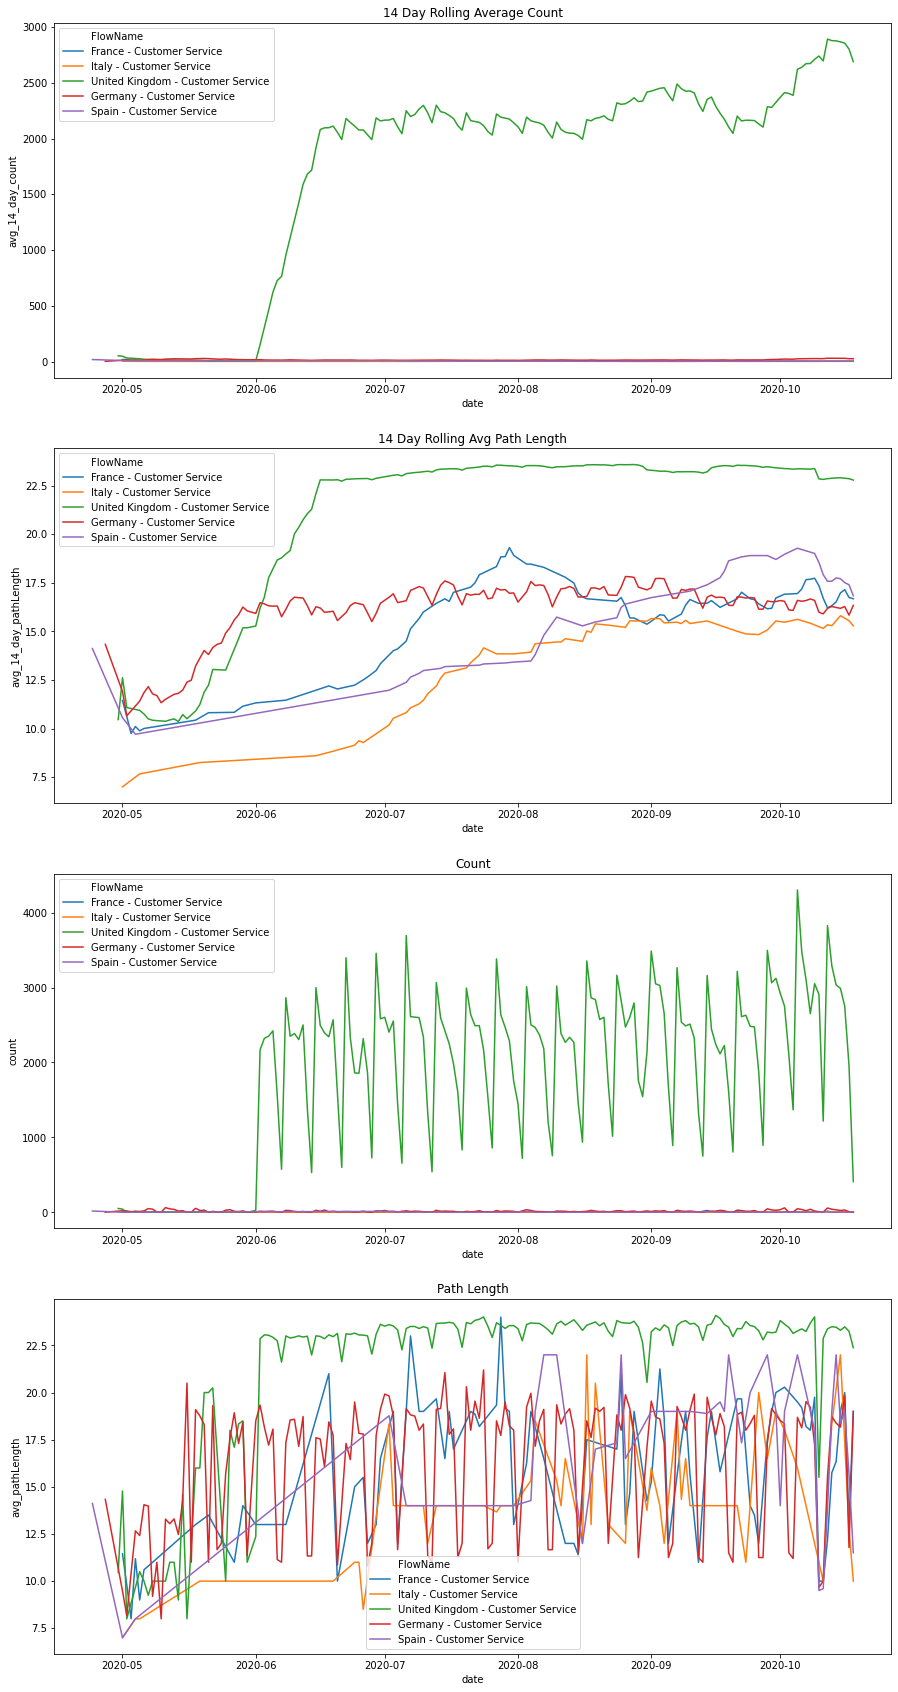

In [87]:
flows = ["United Kingdom - Customer Service", 
         "Italy - Customer Service",
         "France - Customer Service",
         "Spain - Customer Service",
         "Germany - Customer Service"]
time_stats(tuple(flows), 'FlowName')

# Preformance Over Time

The plots compare the 5 flows over two dimensions. 

1. Count - The number of unique SessionIds
2. PathLength - The number of steps present in the ApplicationExitEvent path variable

### Takeaways

- United Kingdom has a much higher volume than the other flows
- United Kingdom has a higher and more stable average path length
- Path lengths differ between weekdays and weekend, probably because SharkNinja is not taking calls on weekends
- The total count of people calling in on weekends is also smaller
- While path lenght for United Kingdom and Germany became stable around June Italy, France, and Spain did not really level out until September.

In [96]:
FlowName =  "United Kingdom - Customer Service"
df = client.query(sql_temp.format(FlowName)).to_dataframe()
flow = SankeyFlow(df)
flow.plot(0, f"{FlowName} Without Trimming").show()

In [90]:
flow.plot(100, f"{FlowName} With Trimming").show()

## United Kingdom - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow. The lower plot shows a trimmed version with only those paths that have over 100 users. 

### Takeaways
- All paths in this flow end in DTMF events
- They appear to enter from two main sources MENU_TREE_17 (MainMenu) or MENU_TREE_6
- The paths from the two entrances are always seperate, it's to say they do not share any nodes

In [97]:
FlowName = "Italy - Customer Service"
df = client.query(sql_temp.format(FlowName)).to_dataframe()
flow = SankeyFlow(df)
flow.plot(0, f"{FlowName} Without Trimming").show()

In [98]:
flow.plot(10, f"{FlowName} With Trimming").show()

## Italy - Customer Service

The upper plot shows all shows all the plots that a SessionId has taken through the flow. The lower plot shows a trimmed version with only those paths that have over 10 users.

## Takeaways


In [15]:
FlowName = "France - Customer Service"
df = client.query(sql_temp.format(FlowName)).to_dataframe()
flow = SankeyFlow(df)
flow.plot(0, f"{FlowName} Without Trimming").show()

In [16]:
flow.plot(10, f"{FlowName} With Trimming").show()

In [17]:
FlowName = "Spain - Customer Service"
df = client.query(sql_temp.format(FlowName)).to_dataframe()
flow = SankeyFlow(df)
flow.plot(0, f"{FlowName} Without Trimming").show()

In [19]:
flow.plot(5, f"{FlowName} With Trimming").show()

In [20]:
FlowName = "Germany - Customer Service"
df = client.query(sql_temp.format(FlowName)).to_dataframe()
flow = SankeyFlow(df)
flow.plot(0, f"{FlowName} Without Trimming").show()

In [22]:
flow.plot(15, f"{FlowName} With Trimming").show()